In [1]:
import numpy as np
from scipy import signal
import seaborn as sns
import scipy.stats as stats
from scipy.ndimage.interpolation import shift
import scipy.interpolate as interpolate
import itertools as it
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from lab.classes.dbclasses import dbMouse
from lab.analysis import behavior_analysis as ba
from lab.misc.auto_helpers import locate
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
%run Helper_Functions.ipynb

In [ ]:
return_all = []
for mousename in ['BV150', 'BV151', 'BV152', 'BV153', 'BV154', 'BV160', 'BV163', 'BV165', \
                  'BV167', 'BV169', 'TG531', 'TG532', 'TG535']:
    exptList_Initial = [expt for expt in dbMouse(mousename).imagingExperiments() if \
                   (expt.experimentType == 'rippleActivity') or \
                    expt.experimentType == 'PreGOL' or expt.experimentType == 'PreSatiety']
    
    print(str(len(exptList_Initial)) + ' experiments:')
    count = 0
    for rippleGroup in np.sort(np.unique((map(lambda x: x.rippleGrp, exptList_Initial)))):
        exptListAll = [expt for expt in exptList_Initial if expt.rippleGrp == rippleGroup]
        dB = []
        for expt_num in np.where((map(lambda x: x.rippleGrp == rippleGroup, exptListAll)))[0]:
            print(str(count)+ ', ' ),
            count = count + 1

            expt = exptListAll[expt_num]
            ripple_frames = loadRippleFrames(expt)
            
            if len(ripple_frames) > 0:
                dff = expt.imagingData(dFOverF='from_file', label='all_fissa')[:,:,0]
                df = pd.read_excel('/data2/bert/CA3/Histology/RippleMice/' + mousename + '_subtypes.xlsx', \
                               sheet_name='group' + str(expt.rippleGrp))
                try:
                    imaging_planes = ROI_planeID(expt, 'all_fissa')
                except:
                    imaging_planes = np.arange(dff.shape[0])
                    
                if len(get_dur_SWR_fr(mousename, expt.trial_id, exptListAll, 0, 20)) > 0:
                    low_dur_frames = get_dur_SWR_fr(mousename, expt.trial_id, exptListAll, 0, 20)
                else:
                    if len(get_dur_SWR_fr(mousename, expt.trial_id, exptListAll, 0, 40)) > 0:
                        low_dur_frames = get_dur_SWR_fr(mousename, expt.trial_id, exptListAll, 0, 40)
                    else:
                        low_dur_frames = get_dur_SWR_fr(mousename, expt.trial_id, exptListAll, 0, 50)
                
                if len(get_dur_SWR_fr(mousename, expt.trial_id, exptListAll, 80, 100)) > 0:
                    high_dur_frames = get_dur_SWR_fr(mousename, expt.trial_id, exptListAll, 80, 100)
                else:
                    if len(get_dur_SWR_fr(mousename, expt.trial_id, exptListAll, 60, 100)) > 0:
                        high_dur_frames = get_dur_SWR_fr(mousename, expt.trial_id, exptListAll, 60, 100)
                    else:
                        high_dur_frames = get_dur_SWR_fr(mousename, expt.trial_id, exptListAll, 50, 100)
            
                low_dur_ripples = ripple_frames[low_dur_frames]
                high_dur_ripples = ripple_frames[high_dur_frames]
            
                window_size_in_sec = 3.00
                window_size_in_frames = int(np.rint(1/expt.frame_period() * window_size_in_sec))
                for icell in range(dff.shape[0]):
                    low_dur_traces = np.zeros((len(np.unique(low_dur_ripples)), \
                                               2 * window_size_in_frames))
                    for n, rtime in enumerate(np.unique(low_dur_ripples)):
                        if ((window_size_in_frames < rtime) & (rtime < (expt.num_frames() - window_size_in_frames))):
                            peri_ripple_trace = dff[icell, (rtime - window_size_in_frames):(rtime + window_size_in_frames)]
                            if len(peri_ripple_trace) > 0:
                                peri_ripple_trace = stats.zscore(peri_ripple_trace)
                                low_dur_traces[n, :] = peri_ripple_trace
                
                    high_dur_traces = np.zeros((len(np.unique(high_dur_ripples)), \
                                                2 * window_size_in_frames))
                    for n, rtime in enumerate(np.unique(high_dur_ripples)):
                        if ((window_size_in_frames < rtime) & (rtime < (expt.num_frames() - window_size_in_frames))):
                            peri_ripple_trace = dff[icell, (rtime - window_size_in_frames):(rtime + window_size_in_frames)]
                            if len(peri_ripple_trace) > 0:
                                peri_ripple_trace = stats.zscore(peri_ripple_trace) 
                                high_dur_traces[n, :] = peri_ripple_trace
                                
                    dB.append({'roiID': imaging_planes[icell], 
                            'type': df['Subtype'][imaging_planes[icell]], 
                            'region': df['Region'][imaging_planes[icell]],
                            'layer': df['Layer'][imaging_planes[icell]],
                            'n_low_dur_ripples': len(np.unique(low_dur_ripples)),     
                            'n_high_dur_ripples': len(np.unique(high_dur_ripples)),
                            'low_dur_trace': np.nanmean(low_dur_traces, axis = 0),
                            'high_dur_trace': np.nanmean(high_dur_traces, axis = 0)})   
            else:
                continue
        dB = pd.DataFrame(dB)
        for planenumber in filter(lambda v: v==v, np.unique(dB['roiID'])):
            low_dur_traces = []
            for array in dB[dB.roiID == planenumber]['low_dur_trace'].values:
                low_dur_traces.append(array)
            low_dur_traces = np.asarray(low_dur_traces)
            
            high_dur_traces = []
            for array in dB[dB.roiID == planenumber]['high_dur_trace'].values:
                high_dur_traces.append(array)
            high_dur_traces = np.asarray(high_dur_traces)
            
            n_low_dur_ripples = np.nansum(dB[dB.roiID == planenumber]['n_low_dur_ripples'])
            n_high_dur_ripples = np.nansum(dB[dB.roiID == planenumber]['n_high_dur_ripples'])
            
            return_all.append({'mouse': mousename, 'grp': rippleGroup, 
                        'Imaging_Plane': planenumber,
                        'Subtype':dB[dB.roiID == planenumber]['type'].iloc[0], 
                        'Region': dB[dB.roiID == planenumber]['region'].iloc[0],
                        'Layer': dB[dB.roiID == planenumber]['layer'].iloc[0],
                        'Avg_Low_Dur_Trace': np.nanmean(low_dur_traces, axis = 0),     
                        'Avg_High_Dur_Trace': np.nanmean(high_dur_traces, axis = 0),
                        'n_low_dur_ripples': n_low_dur_ripples, 
                        'n_high_dur_ripples': n_high_dur_ripples})     
           
                            
return_all = pd.DataFrame(return_all)
filename = 'Waveform_Corr_w_Ripple_Durations_2.pkl'
outfile = open(filename, 'wb')
pickle.dump(return_all, outfile)
outfile.close()

In [3]:
with open('Waveform_Corr_w_Ripple_Durations_2.pkl', 'rb') as f:
    data = pickle.load(f)

In [4]:
data = data[data.Region != 'CA1']
data = data.replace(to_replace = 'Bistr', value = 'SOM')
data = data.replace(to_replace = 'SOM/CB', value = 'SOM')
data = data.replace(to_replace = 'CA2/CA3', value = 'CA3')

/home/bert/.local/lib/python2.7/site-packages/pandas/core/missing.py:44: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


In [5]:
data = data[data.Region == 'CA3']
subtypes = ['PVBC', 'AAC', 'SOM', 'CCK', 'CB']
data = data[data.Subtype.isin(subtypes)]

(75, 600)
(75, 600)
(71, 600)
(71, 600)
(114, 600)
(114, 600)
(32, 600)
(32, 600)
(22, 600)
(22, 600)


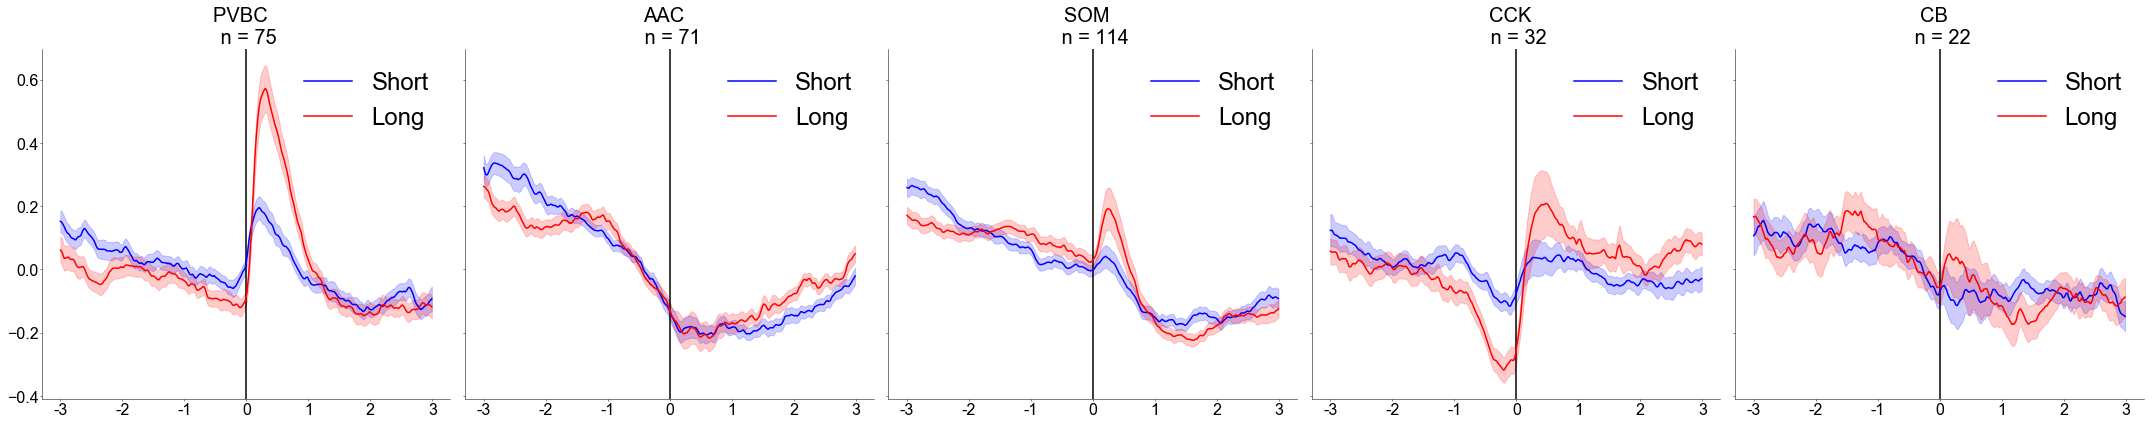

In [6]:
fig, ax = plt.subplots(1, 5, figsize = (30, 6), sharey = True)

data = data[~pd.isnull(data.Avg_Low_Dur_Trace)]
data = data[~pd.isnull(data.Avg_High_Dur_Trace)]
for i, subtype in enumerate(subtypes):
    low_dur_traces= []
    for n, array in enumerate(data[data.Subtype == subtype].Avg_Low_Dur_Trace.values):
        low_dur_traces.append(array)
    resample_traces_low_dur = []
    for arr in low_dur_traces:
        resample_traces_low_dur.append(resample_trace(arr, 600))
    resample_traces_low_dur = np.asarray(resample_traces_low_dur)
    mean_low_dur = np.nanmean(resample_traces_low_dur, axis = 0)
    sem_low_dur = stats.sem(resample_traces_low_dur, axis = 0, nan_policy = 'omit')
    print resample_traces_low_dur.shape
    
    high_dur_traces= []
    for n, array in enumerate(data[data.Subtype == subtype].Avg_High_Dur_Trace.values):
        high_dur_traces.append(array)
    resample_traces_high_dur = []
    for arr in high_dur_traces:
        resample_traces_high_dur.append(resample_trace(arr, 600))
    resample_traces_high_dur = np.asarray(resample_traces_high_dur)
    mean_high_dur = np.nanmean(resample_traces_high_dur, axis = 0)
    sem_high_dur = stats.sem(resample_traces_high_dur, axis = 0, nan_policy = 'omit')
    print resample_traces_high_dur.shape

    ax[i].axvline(x = np.asarray(resample_traces_high_dur).shape[1]/2, color = 'black')
    ax[i].plot(mean_low_dur, color = 'blue', label = 'Short')
    ax[i].fill_between(np.arange(0, mean_low_dur.shape[0]), \
        mean_low_dur - sem_low_dur, mean_low_dur + sem_low_dur, color = 'blue', alpha = 0.2)
    ax[i].plot(mean_high_dur, color = 'red', label = 'Long')
    ax[i].fill_between(np.arange(0, mean_high_dur.shape[0]), \
        mean_high_dur - sem_high_dur, mean_high_dur + sem_high_dur, color = 'red', alpha = 0.2)
    
    ax[i].legend(frameon = False, fontsize = 24, ncol = 1, loc = 'upper right')
    ax[i].set_title(subtype + ' ' + \
            ' \n n = ' + str(resample_traces_low_dur.shape[0]), fontsize = 20)
    ax[i].tick_params(axis = 'x', labelsize = 16)
    ax[i].tick_params(axis = 'y', labelsize = 16)
    ax[i].set_xticks([0, 100, 200, 300, 400, 500, 600])
    ax[i].set_xticklabels([-3, -2, -1, 0, 1, 2, 3])
    #ax[i].set_xticklabels([])
    #ax[i].set_yticklabels([])
    simpleaxis(ax[i])

fig.tight_layout()
plt.savefig('CA3_SWR_Activity_Long_vs_Short_Duration.svg', format = 'svg', \
            dpi = 1200, transparent = True)